## Libraries

All libraries used in this notebook are presented below

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import kagglehub
import uuid
import shutil
import random
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance
import eli5
from eli5.sklearn import explain_prediction_sklearn
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from PIL import Image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import regularizers

## Machine Learning

For the first part, we are gonna choose, train and classify images using a Machine Learning model

#### Import Dataset

In [2]:
# Download latest version from the Dataset
path = kagglehub.dataset_download("uciml/iris")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\LuizFernandoDaCostaC\.cache\kagglehub\datasets\uciml\iris\versions\2


In [3]:
# Load the CSV file
df = pd.read_csv(os.path.join(path, "Iris.csv"))

# Clean column names
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
df.drop(columns=["id"], inplace=True)

df.head()

,sepallengthcm,sepalwidthcm,petallengthcm,petalwidthcm,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


#### Exploratory Data Analysis

In [4]:
# Describe stats about dataframe
print(df.describe())

       sepallengthcm  sepalwidthcm  petallengthcm  petalwidthcm
count     150.000000    150.000000     150.000000    150.000000
mean        5.843333      3.054000       3.758667      1.198667
std         0.828066      0.433594       1.764420      0.763161
min         4.300000      2.000000       1.000000      0.100000
25%         5.100000      2.800000       1.600000      0.300000
50%         5.800000      3.000000       4.350000      1.300000
75%         6.400000      3.300000       5.100000      1.800000
max         7.900000      4.400000       6.900000      2.500000


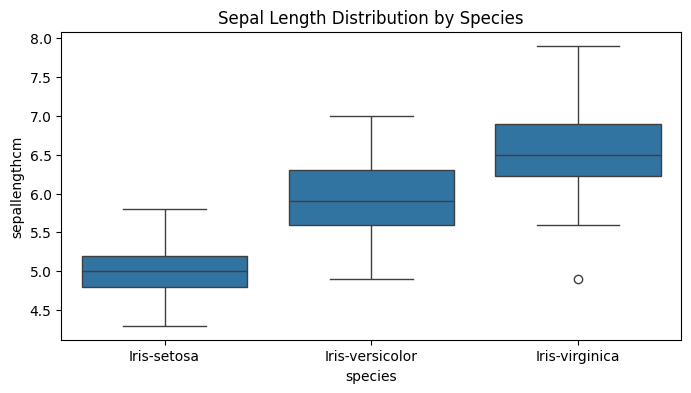

In [5]:
# Plot graphics from the dataframe
plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x="species", y="sepallengthcm")
plt.title("Sepal Length Distribution by Species")
plt.show()

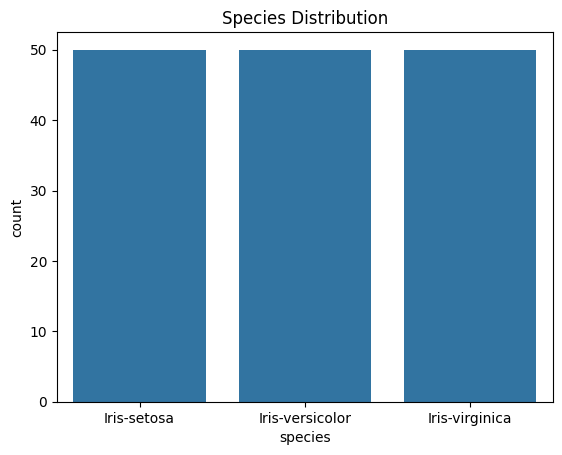

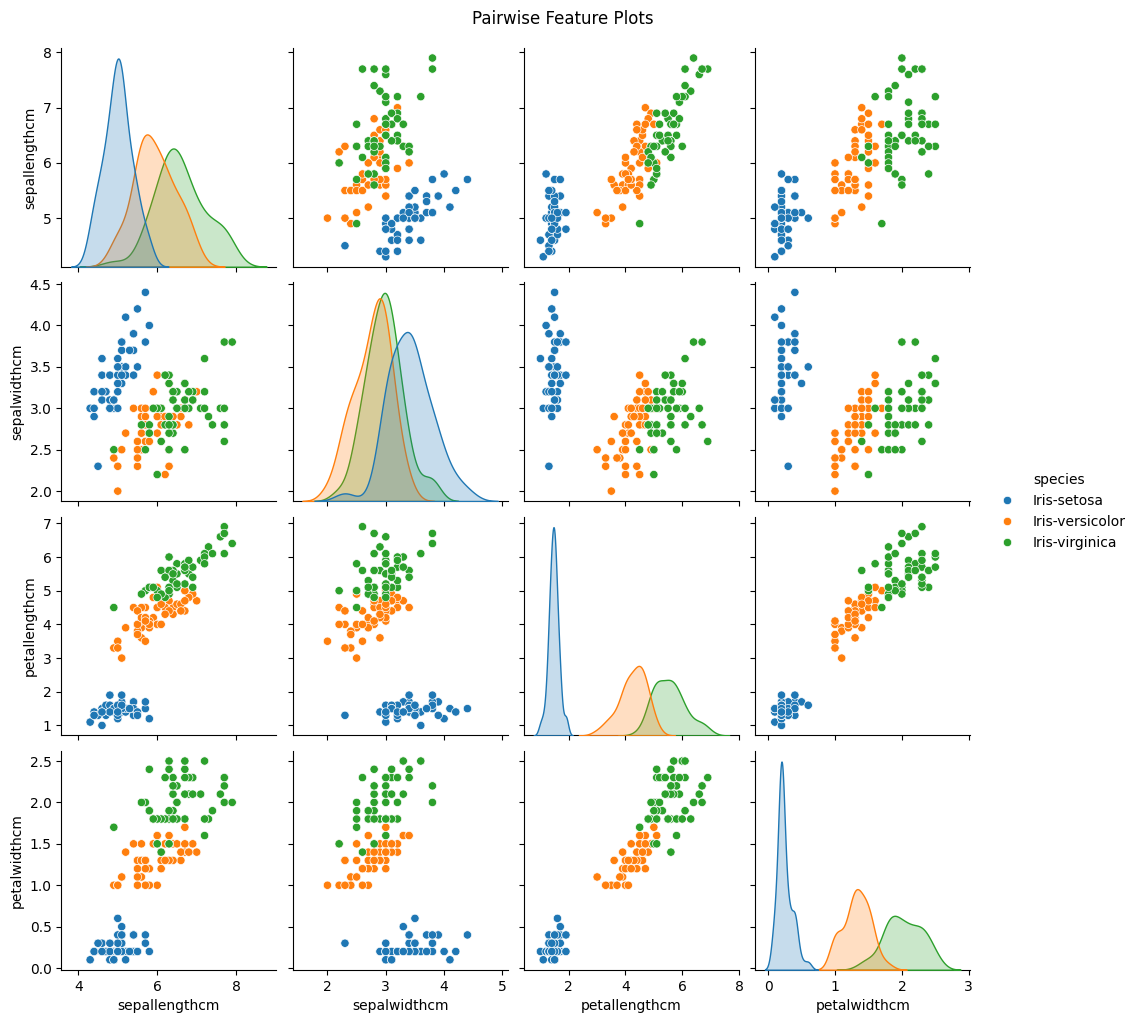

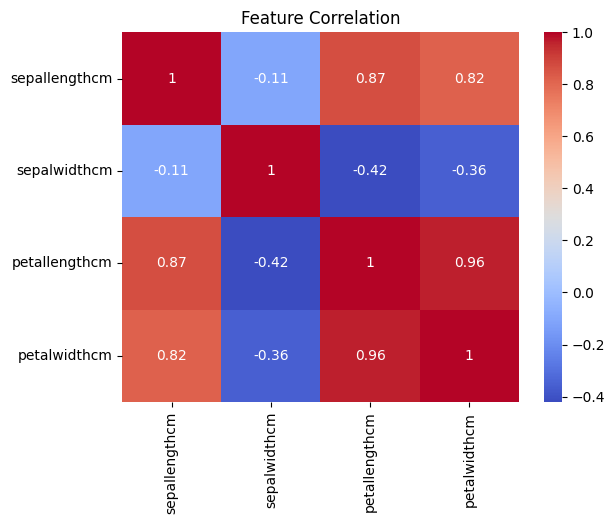

In [6]:
# Count of species
sns.countplot(data=df, x="species")
plt.title("Species Distribution")
plt.show()

# Pairplot
sns.pairplot(df, hue="species")
plt.suptitle("Pairwise Feature Plots", y=1.02)
plt.show()

# Heatmap
sns.heatmap(df.drop(columns=["species"]).corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()


#### Model

In [7]:
# Features and target
X = df.drop(columns=["species"])
y = df["species"]

# Split: 60% train, 20% val, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")


Train size: 90
Validation size: 30
Test size: 30


In [8]:
# Random Forest Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict based on validation dataset
y_val_pred = model.predict(X_val)

print("📋 Validation Results")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))


📋 Validation Results
[[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.90      0.90      0.90        10
 Iris-virginica       0.90      0.90      0.90        10

       accuracy                           0.93        30
      macro avg       0.93      0.93      0.93        30
   weighted avg       0.93      0.93      0.93        30



In [9]:
#Predict on test dataset
y_test_pred = model.predict(X_test)

print("📋 Test Results")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))


📋 Test Results
[[10  0  0]
 [ 0 10  0]
 [ 0  3  7]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.77      1.00      0.87        10
 Iris-virginica       1.00      0.70      0.82        10

       accuracy                           0.90        30
      macro avg       0.92      0.90      0.90        30
   weighted avg       0.92      0.90      0.90        30



### Conclusions

The Random Forest Model was almost perfect to predict the species. The data contained in the table is precise and details the important aspects in the classification of species

### XAI DM Model

Now we are gonna explain how the model makes its predictions and what features are most important for classification

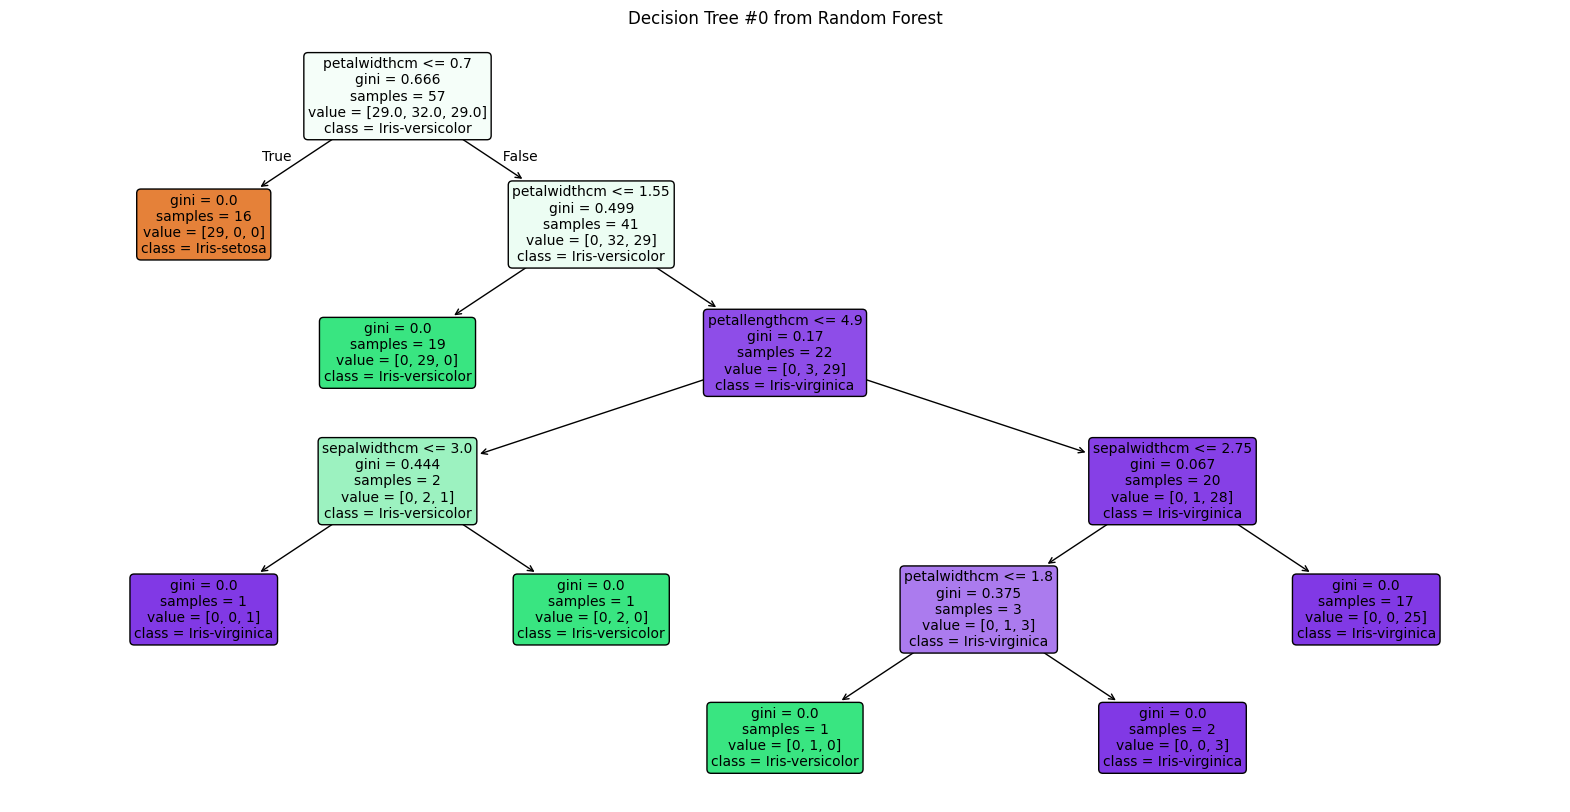

In [10]:
# Pick a tree (e.g., the first one)
tree = model.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(tree,
          feature_names=X.columns,
          class_names=model.classes_,
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Decision Tree #0 from Random Forest")
plt.show()


In [11]:
# Print the first 5 predicted labels and its probabilities from the validation dataset
print(model.predict(X_val[:5]))
print(model.predict_proba(X_val[:5]))


['Iris-virginica' 'Iris-setosa' 'Iris-virginica' 'Iris-versicolor'
 'Iris-versicolor']
[[0.   0.31 0.69]
 [1.   0.   0.  ]
 [0.   0.   1.  ]
 [0.   0.98 0.02]
 [0.07 0.93 0.  ]]


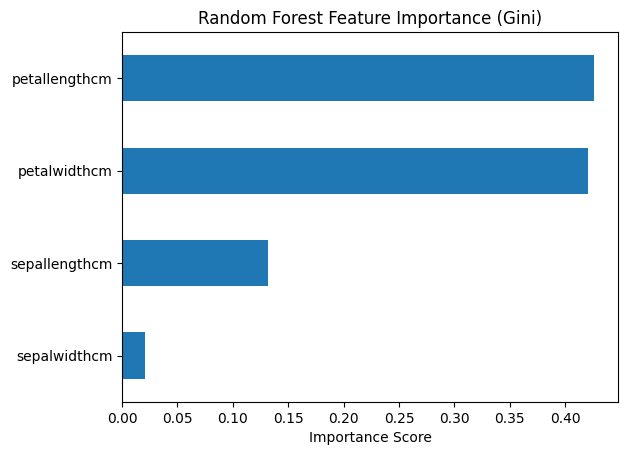

In [12]:
# Get importances
importances = model.feature_importances_

# Create a DataFrame
feat_importance = pd.Series(importances, index=X_train.columns).sort_values(ascending=True)

# Plot
feat_importance.plot(kind='barh')
plt.title("Random Forest Feature Importance (Gini)")
plt.xlabel("Importance Score")
plt.show()


In [13]:
# Run permutation importance on validation set
result_train = permutation_importance(model, X_train, y_train, n_repeats=20, random_state=42, n_jobs=-1)
result_val = permutation_importance(model, X_val, y_val, n_repeats=20, random_state=42, n_jobs=-1)
result_test = permutation_importance(model, X_test, y_test, n_repeats=20, random_state=42, n_jobs=-1)

# Create DataFrame
perm_df_train = pd.Series(result_train.importances_mean * 100, index=X_train.columns).sort_values(ascending=True)
perm_df_val = pd.Series(result_val.importances_mean * 100, index=X_val.columns).sort_values(ascending=True)
perm_df_test = pd.Series(result_test.importances_mean * 100, index=X_test.columns).sort_values(ascending=True)

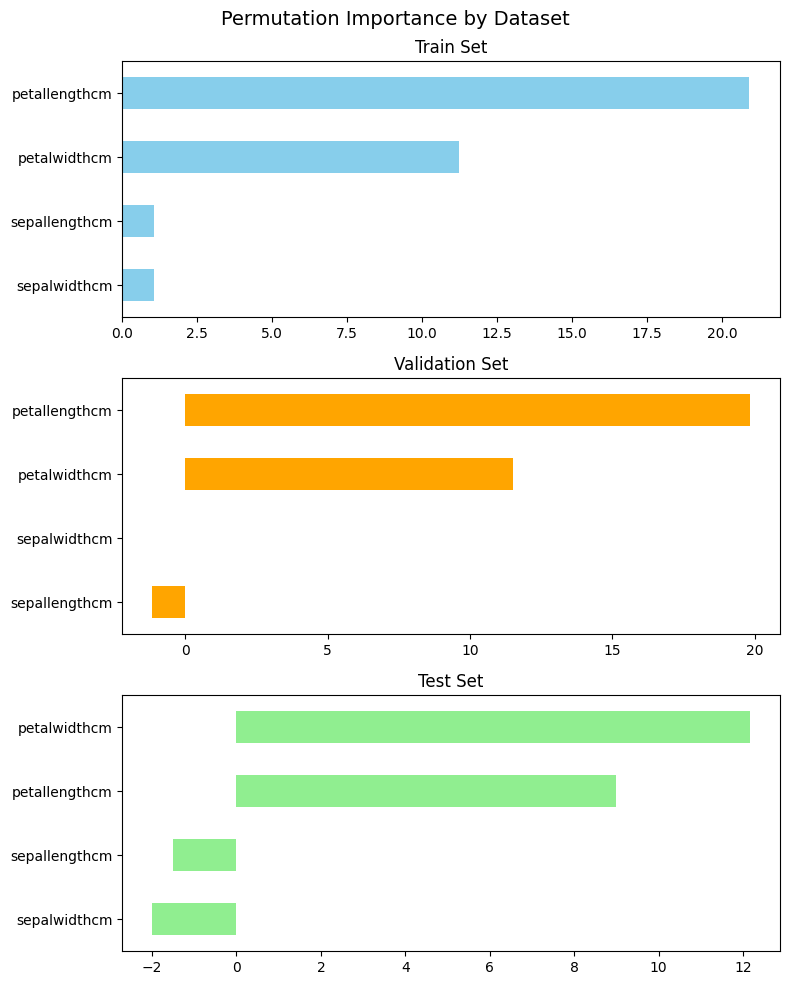

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10))  # 3 rows, 1 column

perm_df_train.plot(kind='barh', ax=axes[0], color='skyblue', title="Train Set")
perm_df_val.plot(kind='barh', ax=axes[1], color='orange', title="Validation Set")
perm_df_test.plot(kind='barh', ax=axes[2], color='lightgreen', title="Test Set")

fig.suptitle("Permutation Importance by Dataset", fontsize=14)
plt.tight_layout()
plt.show()


In [15]:
# Pick a sample from validation set
sample_idx = 0
sample = X_val.iloc[sample_idx]
true_label = y_val.iloc[sample_idx]

print("True label:", true_label)
print("Predicted:", model.predict([sample])[0])

# Show explanation
eli5.show_prediction(model, sample.values, feature_names=X_val.columns.tolist())


True label: Iris-virginica
Predicted: Iris-virginica


c:\Users\LuizFernandoDaCostaC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\LuizFernandoDaCostaC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


#### Conclusions

From a global perspective the most importante feature when making a decision about the label for the Iris Dataset is the Petal Length and a close second place to Petal Width. We then permutated the values from all features to see how that would impact in the accuracy score and got expected results based on the importance of the two mentioned features to the overall classification.
Lastly, we focused on one prediction, that was classified as Iris-virginica and what counted pro and against that decision compared to the other possible classifications.

## Neural Network

### Import dataset

In [16]:
# Download latest version
path = kagglehub.dataset_download("jeffheaton/iris-computer-vision")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\LuizFernandoDaCostaC\.cache\kagglehub\datasets\jeffheaton\iris-computer-vision\versions\1


### Split train, validation and test

In [17]:
# Paths
split_path = "iris_split"
os.makedirs(split_path, exist_ok=True)

categories = os.listdir(path)  # ['iris-setosa', 'iris-versicolor', 'iris-virginica']

# Create split folders
for split in ['train', 'val', 'test']:
    for category in categories:
        os.makedirs(os.path.join(split_path, split, category), exist_ok=True)

# Split ratios
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Shuffle and split files
for category in categories:
    imgs = os.listdir(os.path.join(path, category))
    random.shuffle(imgs)
    
    n_total = len(imgs)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    n_test = n_total - n_train - n_val
    
    train_imgs = imgs[:n_train]
    val_imgs = imgs[n_train:n_train+n_val]
    test_imgs = imgs[n_train+n_val:]
    
    # Copy images to new folders
    for img_name in train_imgs:
        src = os.path.join(path, category, img_name)
        dst = os.path.join(split_path, 'train', category, img_name)
        shutil.copyfile(src, dst)
    for img_name in val_imgs:
        src = os.path.join(path, category, img_name)
        dst = os.path.join(split_path, 'val', category, img_name)
        shutil.copyfile(src, dst)
    for img_name in test_imgs:
        src = os.path.join(path, category, img_name)
        dst = os.path.join(split_path, 'test', category, img_name)
        shutil.copyfile(src, dst)

print("Data split into train/val/test folders!")


Data split into train/val/test folders!


In [18]:
# Resize images to 128x128

# --- Configuration ---
input_base_dir = "iris_split" 
output_base_dir = "iris_resized"
target_size = (128, 128)

def resize_with_padding(img, target_size=(128, 128)):
    img.thumbnail(target_size, Image.LANCZOS)  # Resize proportionally

    # Create new image with white background
    new_img = Image.new("RGB", target_size, (255, 255, 255))
    new_img.paste(
        img,
        ((target_size[0] - img.size[0]) // 2, (target_size[1] - img.size[1]) // 2)
    )
    return new_img

# --- Process splits and categories ---
splits = ["train", "val", "test"]

for split in splits:
    input_split_path = os.path.join(input_base_dir, split)
    output_split_path = os.path.join(output_base_dir, split)
    os.makedirs(output_split_path, exist_ok=True)

    for category in os.listdir(input_split_path):
        input_category_path = os.path.join(input_split_path, category)
        output_category_path = os.path.join(output_split_path, category)
        os.makedirs(output_category_path, exist_ok=True)

        for filename in os.listdir(input_category_path):
            if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            input_img_path = os.path.join(input_category_path, filename)
            output_img_path = os.path.join(output_category_path, filename)

            try:
                with Image.open(input_img_path) as img:
                    img = img.convert("RGB")
                    resized = resize_with_padding(img, target_size)
                    resized.save(output_img_path)
            except Exception as e:
                print(f"Error resizing {input_img_path}: {e}")

print("✅ All images resized to 128x128 with padding and saved in 'iris_resized/'")

✅ All images resized to 128x128 with padding and saved in 'iris_resized/'


In [19]:
# Count of species labels in the train dataset
train_dir = "iris_resized/train"
class_counts_train = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in os.listdir(train_dir)}
print("Training class distribution before balancing:")
print(class_counts_train)

Training class distribution before balancing:
{'iris-setosa': 67, 'iris-versicolour': 268, 'iris-virginica': 85}


In [20]:
# Counts of the label with most images
max_count_train = max(class_counts_train.values())

In [21]:
# Data augmentation parameters
augmenter = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    shear_range=0.3,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [22]:
# Oversample each minority class
for cls, count in class_counts_train.items():
    cls_path = os.path.join(train_dir, cls)
    images = os.listdir(cls_path)
    
    n_to_generate = max_count_train - count
    print(f"Generating {n_to_generate} new images for class '{cls}'")

    i = 0
    while i < n_to_generate:
        # Cycle through original images
        img_name = images[i % count]
        img_path = os.path.join(cls_path, img_name)
        
        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)  # batch of 1

        # Generate one new augmented image
        for batch in augmenter.flow(x, batch_size=1, save_to_dir=cls_path, save_prefix='aug', save_format='jpg'):
            i += 1
            break  # Only one image per loop iteration

Generating 201 new images for class 'iris-setosa'
Generating 0 new images for class 'iris-versicolour'
Generating 183 new images for class 'iris-virginica'


In [23]:
# Increase the amount of images in train dataset

# Loop through each class folder
for cls in os.listdir(train_dir):
    cls_path = os.path.join(train_dir, cls)
    images = [img for img in os.listdir(cls_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    current_count = len(images)
    n_to_generate = current_count  # since we want to double the dataset, *2 to triple, *3 to quadriple
    
    print(f"Generating {n_to_generate} new images for class '{cls}'")

    i = 0
    while i < n_to_generate:
        img_name = images[i % current_count]
        img_path = os.path.join(cls_path, img_name)

        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Generate one new image per loop
        for batch in augmenter.flow(x, batch_size=1, save_to_dir=cls_path,
                                    save_prefix='aug', save_format='jpg'):
            i += 1
            break  # one per iteration


Generating 266 new images for class 'iris-setosa'
Generating 268 new images for class 'iris-versicolour'
Generating 267 new images for class 'iris-virginica'


In [24]:
# Parameters for images
img_size = (128, 128)
batch_size = 32

# Validation and Test generator without augmentation
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Augmented train generator
train_generator = augmenter.flow_from_directory(
    "iris_resized/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    "iris_resized/val",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    "iris_resized/test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1581 images belonging to 3 classes.
Found 334 images belonging to 3 classes.
Found 332 images belonging to 3 classes.


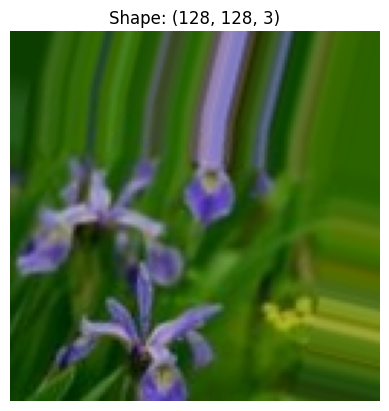

In [25]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
images, labels = next(train_generator)

# Show the first image in the batch
plt.imshow(images[2])
plt.title(f"Shape: {images[0].shape}")
plt.axis('off')
plt.show()

Training set class distribution:
iris-setosa: 524
iris-versicolour: 533
iris-virginica: 524


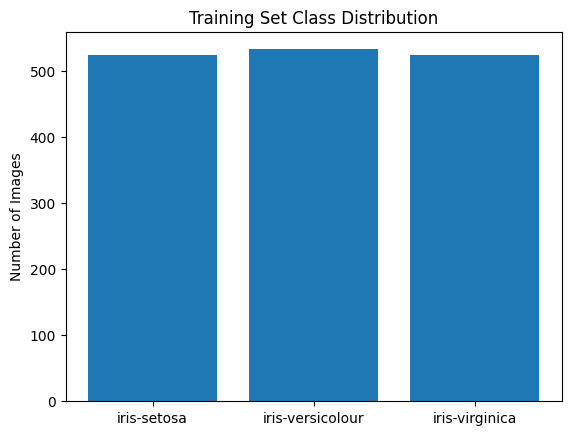

In [26]:
# Check if the oversample worked

# Create index-to-class-name mapping
index_to_class = {v: k for k, v in train_generator.class_indices.items()}

# Count how many images per class
train_class_counts = Counter(train_generator.classes)

# Map indices to class names
train_class_labels = [index_to_class[i] for i in train_class_counts.keys()]

# Print counts
print("Training set class distribution:")
for label, count in zip(train_class_labels, train_class_counts.values()):
    print(f"{label}: {count}")

# Bar plot
plt.bar(train_class_labels, train_class_counts.values())
plt.title("Training Set Class Distribution")
plt.ylabel("Number of Images")
plt.show()


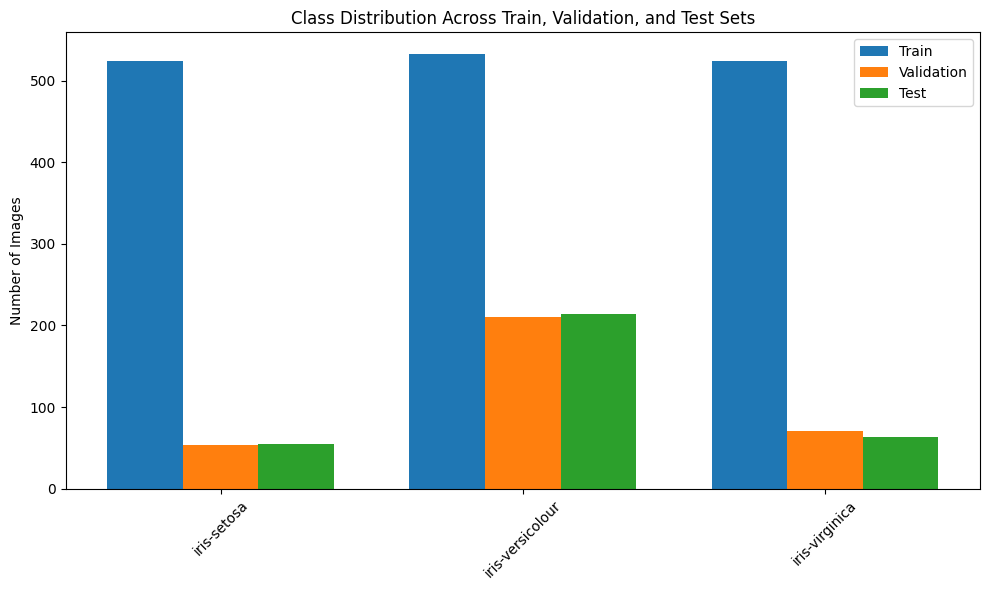

In [27]:
# Inverse mapping from class index to name (same across all generators)
index_to_class = {v: k for k, v in train_generator.class_indices.items()}
class_names = [index_to_class[i] for i in range(len(index_to_class))]

# Count samples per class for each set
train_counts = Counter(train_generator.classes)
val_counts = Counter(val_generator.classes)
test_counts = Counter(test_generator.classes)

# Ensure all class indices are present
train_values = [train_counts.get(i, 0) for i in range(len(class_names))]
val_values = [val_counts.get(i, 0) for i in range(len(class_names))]
test_values = [test_counts.get(i, 0) for i in range(len(class_names))]

# Plot
x = np.arange(len(class_names))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, train_values, width=width, label='Train')
plt.bar(x, val_values, width=width, label='Validation')
plt.bar(x + width, test_values, width=width, label='Test')

plt.xticks(x, class_names, rotation=45)
plt.ylabel("Number of Images")
plt.title("Class Distribution Across Train, Validation, and Test Sets")
plt.legend()
plt.tight_layout()
plt.show()


In [28]:
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,340,163 (8.93 MB)

 Trainable params: 82,179 (321.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy',     # or 'val_accuracy'
    patience=5,             # stop after 3 epochs with no improvement
    restore_best_weights=True
)

In [30]:
# Train the model
# Phase 1 - Feature Extraction
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop]
)

c:\Users\LuizFernandoDaCostaC\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 57s 975ms/step - accuracy: 0.4078 - loss: 1.2346 - val_accuracy: 0.7066 - val_loss: 0.7851
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 707ms/step - accuracy: 0.6088 - loss: 0.8685 - val_accuracy: 0.7096 - val_loss: 0.6760
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 38s 768ms/step - accuracy: 0.6769 - loss: 0.8028 - val_accuracy: 0.7635 - val_loss: 0.6329
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 715ms/step - accuracy: 0.6883 - loss: 0.7500 - val_accuracy: 0.6976 - val_loss: 0.7112
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 981ms/step - accuracy: 0.7171 - loss: 0.7227 - val_accuracy: 0.7425 - val_loss: 0.6144
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 47s 933ms/step - accuracy: 0.7399 - loss: 0.6642 - val_accuracy: 0.7335 - val_loss: 0.6436
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 38s 755ms/step - accuracy: 0.7490 - loss: 0.6276 - val_accuracy: 0.7515 - val_loss: 0.6224
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 818ms/step - accuracy: 0.7714 - loss: 0.6022 - val_accu

In [31]:
# Phase 2: Fine-tuning
base_model.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower LR for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_generator,
          validation_data=val_generator,
          epochs=10,
          callbacks=[early_stop]
          )


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.5419 - loss: 1.0603 - val_accuracy: 0.8054 - val_loss: 0.4994
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.5784 - loss: 0.9513 - val_accuracy: 0.7934 - val_loss: 0.5278
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.6361 - loss: 0.8571 - val_accuracy: 0.7784 - val_loss: 0.5490
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.6900 - loss: 0.7832 - val_accuracy: 0.7725 - val_loss: 0.5683
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.6955 - loss: 0.7506 - val_accuracy: 0.7695 - val_loss: 0.5867
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.6918 - loss: 0.7127 - val_accuracy: 0.7665 - val_loss: 0.5976


In [32]:
# Test the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 475ms/step - accuracy: 0.8085 - loss: 0.5018
Test accuracy: 0.7892


In [33]:
# Step 1: Predict class probabilities on test set
pred_probs = model.predict(test_generator)

# Step 2: Convert predicted probabilities to predicted class indices
predicted_indices = np.argmax(pred_probs, axis=1)

# Step 3: Get true class indices from test_generator
true_indices = test_generator.classes  # this gives the true label indices

# Step 4: Get mapping from indices to class names
idx_to_class = {v: k for k, v in test_generator.class_indices.items()}


11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 743ms/step


In [34]:
# Classification report with precision, recall, f1-score by class
print(classification_report(true_indices, predicted_indices, target_names=list(idx_to_class.values())))

# Find misclassified indices
misclassified_indices = np.where(true_indices != predicted_indices)[0]

# Create a list of (true_class, predicted_class) for errors
errors = [(idx_to_class[true_indices[i]], idx_to_class[predicted_indices[i]]) for i in misclassified_indices]

# Count occurrences of each error pair
error_counts = Counter(errors)

print("Misclassification counts (True class -> Predicted class):")
for (true_cls, pred_cls), count in error_counts.items():
    print(f"{true_cls} -> {pred_cls}: {count}")


                  precision    recall  f1-score   support

     iris-setosa       0.70      0.78      0.74        55
iris-versicolour       0.84      0.85      0.84       214
  iris-virginica       0.68      0.60      0.64        63

        accuracy                           0.79       332
       macro avg       0.74      0.74      0.74       332
    weighted avg       0.79      0.79      0.79       332

Misclassification counts (True class -> Predicted class):
iris-setosa -> iris-versicolour: 12
iris-versicolour -> iris-setosa: 15
iris-versicolour -> iris-virginica: 18
iris-virginica -> iris-versicolour: 22
iris-virginica -> iris-setosa: 3


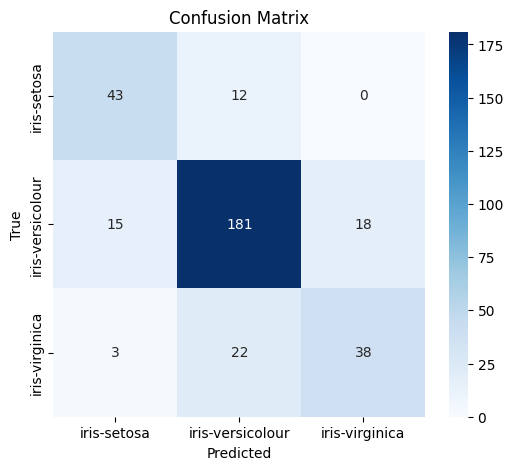

In [35]:
# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(true_indices, predicted_indices)
class_labels = list(test_generator.class_indices.keys())

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Conclusions

While CNN models are impressive, they rely on a lot of input information. If the dataset is not large enough, even with augmented techniques it will have worse results compared to Machine Learning models that can count with well documented data

### XAI CNN Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


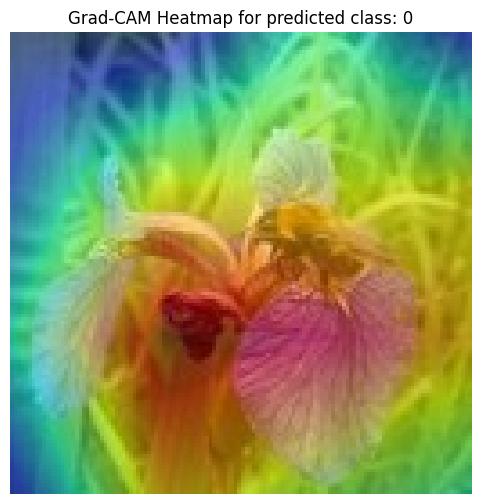

In [ ]:
# Helper to preprocess and display image
def load_and_preprocess(img_path, target_size=img_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0), img

# Choose an image
img_path = test_generator.filepaths[4]  # for example
img_input, original_img = load_and_preprocess(img_path)

model_wo_softmax = model  # Use original model directly

# Define score function for the true class
preds = model.predict(img_input)
pred_class_idx = np.argmax(preds[0])
score = CategoricalScore(pred_class_idx)

# Run Grad-CAM
gradcam = Gradcam(model_wo_softmax)
cam = gradcam(score, img_input)[0]  # shape: (128, 128)

# Display
plt.figure(figsize=(6, 6))
plt.imshow(original_img)
plt.imshow(cam, cmap='jet', alpha=0.5)  # overlay
plt.title(f"Grad-CAM Heatmap for predicted class: {pred_class_idx}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
=== Correctly classified example ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


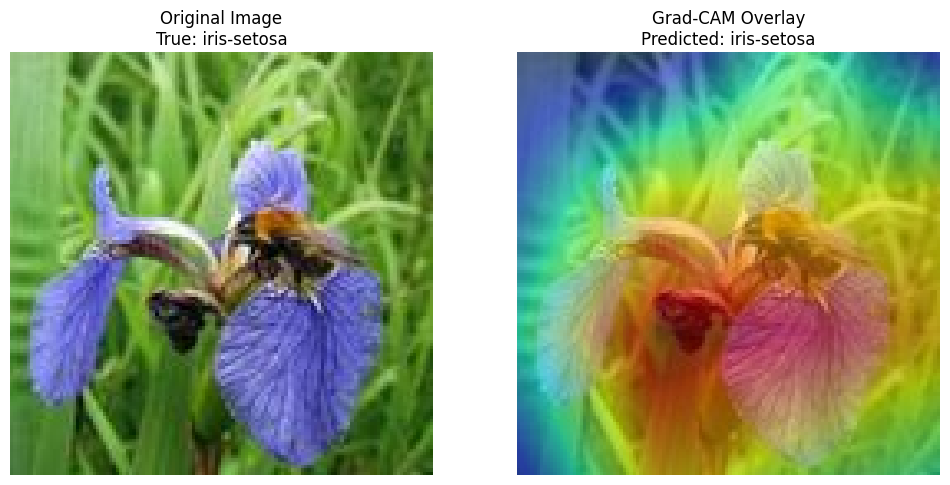

=== Misclassified example ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


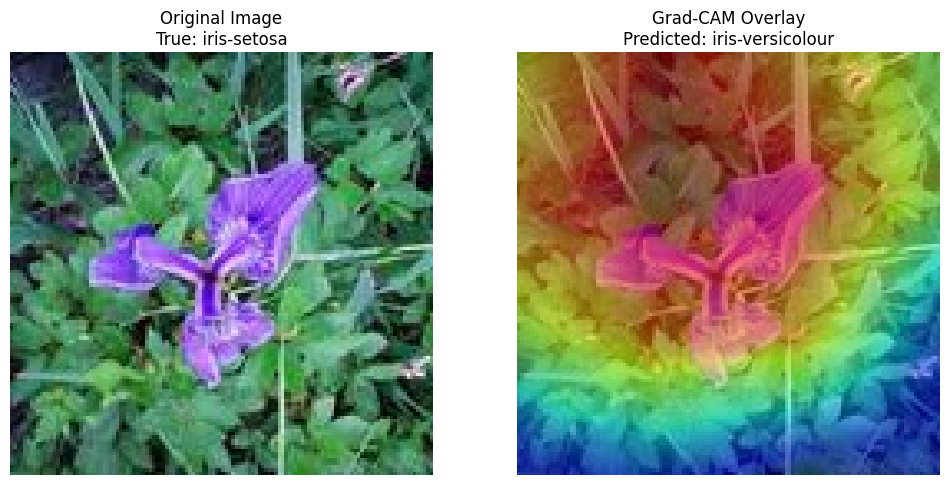

In [37]:
# Assuming these are defined:
# model, test_generator, img_size (e.g. (128, 128))
# idx_to_class dictionary that maps class indices to class names

def show_gradcam(idx):
    # Load and preprocess image
    img_path = test_generator.filepaths[idx]
    original_img = plt.imread(img_path)
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_input = np.expand_dims(img_array, axis=0)
    
    # Predict
    preds = model.predict(img_input)
    pred_class_idx = np.argmax(preds[0])
    true_class_idx = test_generator.classes[idx]
    
    # Get class names
    pred_class_name = idx_to_class[pred_class_idx]
    true_class_name = idx_to_class[true_class_idx]
    
    # Grad-CAM score and heatmap
    score = CategoricalScore(pred_class_idx)
    gradcam = Gradcam(model)
    cam = gradcam(score, img_input)[0]
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)  # Normalize 0-1
    
    # Plot original and overlay
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title(f"Original Image\nTrue: {true_class_name}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(original_img)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title(f"Grad-CAM Overlay\nPredicted: {pred_class_name}")
    plt.axis('off')
    
    plt.show()

# Find one correct and one wrong prediction index
correct_idx = None
wrong_idx = None

for i in range(len(test_generator.filepaths)):
    img_path = test_generator.filepaths[i]
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_input = np.expand_dims(img_array, axis=0)
    
    preds = model.predict(img_input)
    pred_class_idx = np.argmax(preds[0])
    true_class_idx = test_generator.classes[i]
    
    if pred_class_idx == true_class_idx and correct_idx is None:
        correct_idx = i
    if pred_class_idx != true_class_idx and wrong_idx is None:
        wrong_idx = i
    if correct_idx is not None and wrong_idx is not None:
        break

print("=== Correctly classified example ===")
show_gradcam(correct_idx)

print("=== Misclassified example ===")
show_gradcam(wrong_idx)



In [38]:
#Delete iris_resized folder for easiness of replicating

resized_path = "iris_resized"

if os.path.exists(resized_path):
    shutil.rmtree(resized_path)
    print(f"✅ Folder '{resized_path}' deleted successfully.")
else:
    print(f"⚠️ Folder '{resized_path}' does not exist.")

✅ Folder 'iris_resized' deleted successfully.


### Conclusions